First lets create the Knowledge Base as a graph, the idea is to take a big chunk of text ( maybe from a pdf or via webscraping ) and then break all of that into sentences ( split with `.` ) and then basically create a graph , where each sentence will become a node, and edges between `(u,v)` is present if they are `similar`

Now for this `similarity` we will use some kind of transformer, to convert sentences into embeddings , and then check their cosine similarity.

This will be used during knowledge base graph generation as well as when checking if a certain node is actually the goal node ( we will have some kind of threshold if `cosine_similarity(s,current_node)>threshold` then `current_node` is the goal state )

For our knowledge base we will use the following text

In [ ]:
text = """
During floods, residents are advised to boil drinking water for at least ten minutes.
Contaminated water can cause diseases such as cholera and diarrhea.
Government health advisories recommend using chlorine tablets if clean water is unavailable.
Farmers affected by floods may apply for disaster assistance within thirty days of the incident.
Compensation is provided based on crop damage assessment by local authorities.
For pest attacks, the agriculture department suggests using eco-friendly pesticides approved by ICAR.
Farmers are encouraged to report pest outbreaks immediately to the nearest agriculture officer.
Health centers in rural areas are stocked with essential medicines for water-borne diseases.
The Ministry of Agriculture offers subsidy programs for small farmers purchasing bio-fertilizers.
Applicants must submit land ownership documents to claim these subsidies.
Public awareness campaigns promote hygiene and safe food handling after natural disasters.
District officials coordinate relief camps and ensure clean water distribution.
"""

In [ ]:
sentences = text.split('.')
sentences = [s.strip() for s in sentences if s.strip()] # to remove the \n
print(sentences)

['During floods, residents are advised to boil drinking water for at least ten minutes', 'Contaminated water can cause diseases such as cholera and diarrhea', 'Government health advisories recommend using chlorine tablets if clean water is unavailable', 'Farmers affected by floods may apply for disaster assistance within thirty days of the incident', 'Compensation is provided based on crop damage assessment by local authorities', 'For pest attacks, the agriculture department suggests using eco-friendly pesticides approved by ICAR', 'Farmers are encouraged to report pest outbreaks immediately to the nearest agriculture officer', 'Health centers in rural areas are stocked with essential medicines for water-borne diseases', 'The Ministry of Agriculture offers subsidy programs for small farmers purchasing bio-fertilizers', 'Applicants must submit land ownership documents to claim these subsidies', 'Public awareness campaigns promote hygiene and safe food handling after natural disasters', 

Lets take one transformer to convert Sentences into embeddings

In [ ]:
from sentence_transformers import SentenceTransformer # for the model
from sentence_transformers import util # for similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

a = "Boil drinking water after floods to prevent disease."
b = "Is Water drinkable here after flood ?"

# Convert to embedding (vector)
a_emb = model.encode(a)
b_emb = model.encode(b)

print(a_emb.shape)
print(b_emb.shape)


emb1 = model.encode(a, convert_to_tensor=True)
emb2 = model.encode(b, convert_to_tensor=True)

similarity = util.cos_sim(emb1, emb2).item()
print(f"Similarity: {similarity:.2f}")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(384,)
(384,)
Similarity: 0.69


Lets actually create a function so thats its easier on us

In [ ]:
def sim(a,b):
  if isinstance(a,int):
    a = sentences[a]
    b = sentences[b]

  emb1 = model.encode(a, convert_to_tensor=True)
  emb2 = model.encode(b, convert_to_tensor=True)

  similarity = util.cos_sim(emb1, emb2).item()
  return similarity

Now lets make a graph , for the graph , what would be better ? an adjacency matrix or a adjacency list ? for small scale an adjacency matrix would be helpful , but for larger Knowledge bases an adjacency list would be better.
Actually lets make both ?

In [ ]:
# I tried with 0.6 and basically no connectinos were forming
sim_thresh_1 = 0.3
adj_list = {}
for i in range(len(sentences)):
    adj_list[i]=[]
    for j in range(len(sentences)):
        if i!=j and sim(sentences[i],sentences[j])>=sim_thresh_1:
          adj_list[i].append(j)


In [ ]:
adj_list

{0: [1, 3, 7, 11, 12],
 1: [0, 2, 7, 10],
 2: [1, 5, 7, 10, 11],
 3: [0, 4, 6, 8, 9, 10, 11],
 4: [3, 5, 6, 8, 9],
 5: [2, 4, 6],
 6: [3, 4, 5, 7, 8, 10],
 7: [0, 1, 2, 6, 11],
 8: [3, 4, 6, 9],
 9: [3, 4, 8],
 10: [1, 2, 3, 6, 11],
 11: [0, 2, 3, 7, 10],
 12: [0]}

Lets try to see the Knowledge base a bit

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_sentence_graph(adj_list, sentences=None, title="Sentence Similarity Graph"):
    """
    Draws a graph from an adjacency list representing sentence connections.

    Parameters:
        adj_list (dict): Dictionary mapping node index -> list of connected node texts or indices
        sentences (list, optional): List of sentences corresponding to node indices
        title (str, optional): Title for the plot
    """
    G = nx.Graph()

    # add edges based on adjacency list
    for i, neighbors in adj_list.items():
        for neighbor in neighbors:
            if isinstance(neighbor, int):
                j = neighbor
            elif sentences is not None and neighbor in sentences:
                j = sentences.index(neighbor)
            else:
                continue
            G.add_edge(i, j)

    # draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=500,
        font_size=8,
        font_weight='bold'
    )
    plt.title(title)
    plt.show()


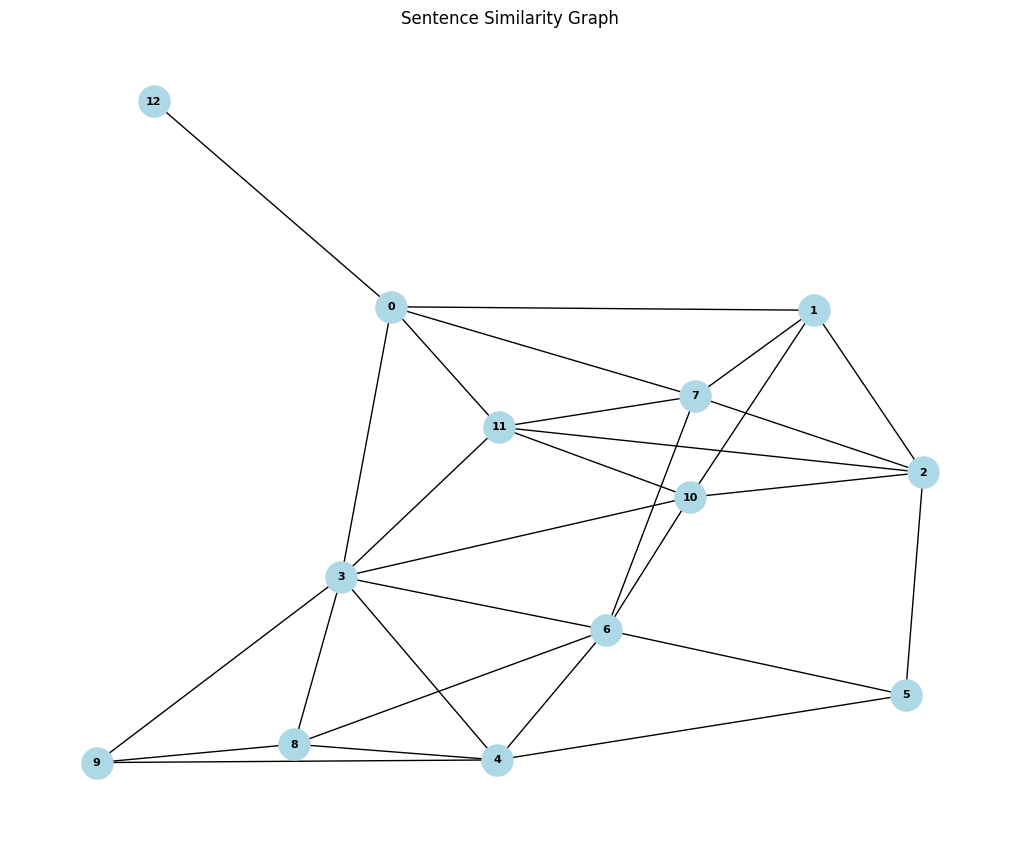

In [ ]:
plot_sentence_graph(adj_list,sentences)

Now lets try to implement A* on it, but for that we need to ... get a heuristic ? what could be a good heuristic ? Is our cosine similarity not a good heuristic ?

But we are using that cosine similarity to find the goal as well , so in a way its the perfect heuristic

Actually now , heuristic of the goal should be 0 , ideally , but in our case if we get a perfect match then the cosine similarity will come as 1 right , so how about we use
$$h(x) = 1 - \text{cosine_similarity}(x,s)$$


Lets write the A* algorithm down a bit :
first start with the start node , expand , and find its children , for each children we need to note down three things , which node is its parent ? and ... the path cost from start to this node , we also add the heuristic , actually lets make a class or function so that we can change the heuristic functions later on

But what should the cost be ? $f(x)$ , sorry not f(x) , but g(x) ,
it should be somethign i want to minimize ... ? but in this case what do i want to minimize ? its the (1-cos(x,s)) thing , but that thing is per node , but the cost thing generally adds up.


Lets add Our temporary search text / embedding to it

In [ ]:
search_text = "Should I boil water or just directly consume it?"
search_emb = model.encode(search_text, convert_to_tensor=True)

In [ ]:


# now add it to the adj_list as the last new index
n = len(adj_list)
adj_list[n]=[]
for i in range(len(sentences)):
  if sim(search_text,sentences[i])>=sim_thresh_1:
    adj_list[n].append(i)

sentences.append(search_text)

NameError: name 'adj_list' is not defined

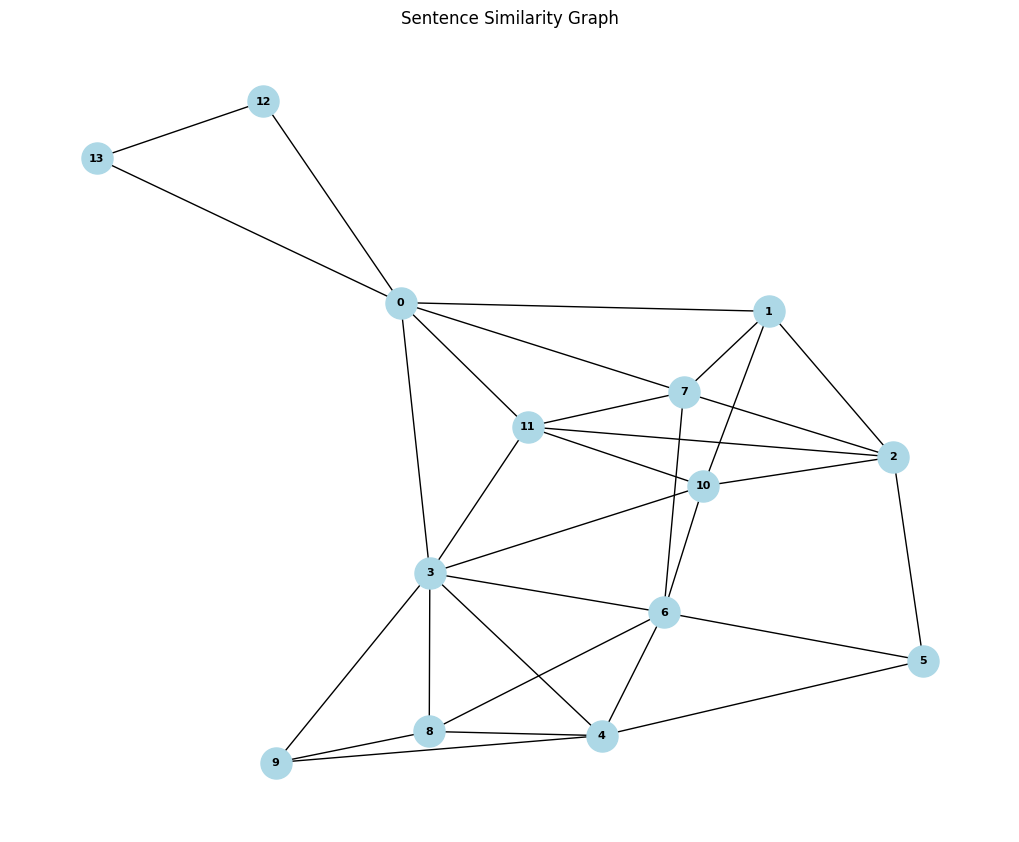

In [ ]:
plot_sentence_graph(adj_list,sentences)

Now that we have added the extra node to the Other nodes , lets find the goal ... but the problem again is the fact that we dont know the goal state , we dont definitely know if a goal state has been reached

In [ ]:
def cost(index_a , index_b):
  return 1-sim(sentences[index_a],sentences[index_b])

def h(index_a):
  return 1-sim(search_text,sentences[index_a])


In [ ]:
open = []
close = []
open.append((n,0,))

In [ ]:
from sentence_transformers import SentenceTransformer # for the model
from sentence_transformers import util # for similarity
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
class Model:
  version = "Base Model with sentences as embeddings"
  sentences = []
  embeddings = []
  def __init__(self):
    print("Model initialised Needs input")

  def make_knowledge_base(self,sentences):

    model = SentenceTransformer('all-MiniLM-L6-v2')
    self.sentences = sentences
    self.sentences = text.split('.')
    self.sentences = [s.strip() for s in self.sentences if s.strip()] # to remove the \n
    self.model = SentenceTransformer('all-MiniLM-L6-v2')
    # what else is needed to make an A* ? do i need an index map ? like 0 -> "hello world ... " ?
    # Also I should probably store all the embedding so that I dont have to compute multiple times ...
    #  lets do that in a map ? or array will do
    for i in self.sentences:
      self.embeddings.append(self.model.encode(i),convert_to_tensor=True)

    # now lets make an adjancency list
    self.adj_list = {}
    for i in range(len(self.sentences)):
        self.adj_list[i]=[]
        for i in range(len(self.sentences)):
            if i!=j and sim(self.sentences[i],self.sentences[j])>=sim_thresh_1:
              self.adj_list[i].append(self.sentences[j])
              self.adj_list[j].append(self.sentences[i])

    # now that adj list is applied , knowledge base is established
  def show_knowledge_base(self):


    # assume adj_list is a dictionary { node_index: [list_of_connected_nodes] }

    G = nx.Graph()

    # add edges based on adjacency list
    for i, neighbors in self.adj_list.items():
        for neighbor_text in neighbors:
            j = sentences.index(neighbor_text)
            G.add_edge(i, j)

    # draw the graph
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)  # layout algorithm for positioning
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightblue',
        node_size=500,
        font_size=8,
        font_weight='bold'
    )
    plt.title("Sentence Similarity Graph")
    plt.show()

  def search(self , s):
    # where s is a string , my goal is to convert it into an embedding and
    # add it to the adjacency list , temporariliy ... or should i permanently add it ?
    s_emb = self.model.encode(s)
    self


In [ ]:
a = Model()
a.make_knowledge_base(text)
a.show_knowledge_base()

Model initialised Needs input


NameError: name 'SentenceTransformer' is not defined

In [ ]:
from collections import deque

In [ ]:
import heapq

# i need to make an A* algo so that even if i change the heuristic and cost functions , it will still work
def Astar(h,c,start, goal_thres=0.5):
  open = []
  history = []
  # what is the structure of each node [ parent , cost upto this node , heuristic + cost ,index ,  ... ]
  heapq.heappush(open, ("None",0,10,start))
  close = []
  while len(open)>0:
    current = heapq.heappop(open)
    history.append(current)
    print(f" Current node is {current}")
    print(f" Queue is {open}")
    id = current[3]
    # also need to check the goal state , ie if i have reached the goal
    if(id!=start and sim(id,start)>= goal_thres):
      print("Goal Reached")
      return history
    # now i need to find its childrens
    print(f" Neighbours of current is {adj_list[current[3]]}")
    for i in adj_list[current[3]]:
      if i not in close:

        child = i
        # and for each children i need to add a node to the open
        path_cost = current[1]+c(id,child)
        heapq.heappush(open, (id , path_cost, path_cost+h(child) , child ))
    # now i need to sort them i guess
    # (heapq already maintains order, so no need to sort explicitly)
    close.append(id)
  return history


In [ ]:
history = Astar(h,cost,n,1)

 Current node is ('None', 0, 10, 13)
 Queue is []
 Neighbours of current is [0, 12]
 Current node is (13, 5.960464477539063e-08, 1.1920928955078125e-07, 12)
 Queue is [(13, 0.3803865909576416, 0.7607731819152832, 0)]
 Neighbours of current is [0]
 Current node is (12, 0.3803866505622864, 0.760773241519928, 0)
 Queue is [(13, 0.3803865909576416, 0.7607731819152832, 0)]
 Neighbours of current is [1, 3, 7, 11, 12]
 Current node is (0, 0.9167440533638, 1.8049220144748688, 3)
 Queue is [(0, 1.0251216888427734, 1.8484778255224228, 11), (0, 1.0784830152988434, 1.849526196718216, 7), (0, 1.0423040688037872, 1.7929354757070541, 1), (13, 0.3803865909576416, 0.7607731819152832, 0)]
 Neighbours of current is [0, 4, 6, 8, 9, 10, 11]
 Current node is (0, 1.0251216888427734, 1.8484778255224228, 11)
 Queue is [(0, 1.0423040688037872, 1.7929354757070541, 1), (0, 1.0784830152988434, 1.849526196718216, 7), (3, 1.4928127825260162, 2.3161689192056656, 11), (3, 1.5097019374370575, 2.4213872104883194, 10), (

In [ ]:
def print_history_sentences(history):
  print("\n=== Path / History Sentences ===")
  for node in history:
    idx = node[3]
    if isinstance(idx, int) and 0 <= idx < len(sentences):
      print(f"[{idx}] {sentences[idx]}")
    else:
      print(f"[{idx}] <Invalid index>")

print_history_sentences(history)


=== Path / History Sentences ===
[13] Should I boil water or just directly consume it?
[12] Should I boil water or just directly consume it?
[0] During floods, residents are advised to boil drinking water for at least ten minutes
[3] Farmers affected by floods may apply for disaster assistance within thirty days of the incident
[11] District officials coordinate relief camps and ensure clean water distribution
[1] Contaminated water can cause diseases such as cholera and diarrhea
[7] Health centers in rural areas are stocked with essential medicines for water-borne diseases
[7] Health centers in rural areas are stocked with essential medicines for water-borne diseases
[2] Government health advisories recommend using chlorine tablets if clean water is unavailable
[10] Public awareness campaigns promote hygiene and safe food handling after natural disasters
[5] For pest attacks, the agriculture department suggests using eco-friendly pesticides approved by ICAR
[10] Public awareness camp

The above was using sentences as one units , now lets try to break the whole knowledge into tokens( actually words for our intents and purposes )

In [ ]:
from collections import defaultdict
import re

tokens = re.findall(r'\b\w+\b', text.lower())
words = list(set(tokens))  # unique vocabulary

print(f"Total unique words: {len(words)}")
print(words)
word_embs = model.encode(words, convert_to_tensor=True)
word_embs

Total unique words: 116
['within', 'handling', 'report', 'during', 'thirty', 'of', 'compensation', 'crop', 'distribution', 'are', 'public', 'if', 'after', 'government', 'local', 'ministry', 'chlorine', 'at', 'immediately', 'friendly', 'such', 'rural', 'submit', 'centers', 'contaminated', 'department', 'and', 'outbreaks', 'promote', 'cholera', 'nearest', 'by', 'may', 'cause', 'water', 'is', 'with', 'diseases', 'subsidies', 'ownership', 'advised', 'officials', 'awareness', 'floods', 'advisories', 'diarrhea', 'camps', 'fertilizers', 'safe', 'incident', 'pesticides', 'food', 'least', 'essential', 'minutes', 'encouraged', 'assessment', 'drinking', 'hygiene', 'agriculture', 'assistance', 'authorities', 'eco', 'health', 'the', 'must', 'ensure', 'approved', 'applicants', 'apply', 'to', 'as', 'ten', 'medicines', 'unavailable', 'residents', 'can', 'small', 'days', 'affected', 'coordinate', 'these', 'clean', 'recommend', 'land', 'district', 'disaster', 'documents', 'offers', 'campaigns', 'attacks

tensor([[ 0.0024, -0.0177, -0.0237,  ..., -0.0125,  0.0370,  0.0571],
        [-0.0425,  0.0965,  0.0247,  ..., -0.0057,  0.0584,  0.0494],
        [ 0.0012,  0.1002, -0.0484,  ..., -0.0453,  0.0718,  0.0618],
        ...,
        [-0.0243, -0.0174, -0.0619,  ..., -0.0933,  0.1593,  0.1314],
        [-0.0045,  0.0388, -0.0608,  ...,  0.0641,  0.0393,  0.0021],
        [-0.0426, -0.0286, -0.0127,  ...,  0.0467,  0.0743, -0.0017]])

Building another adj list named `adj`

In [ ]:
def s(a,b):
  return util.cos_sim(word_embs[a],word_embs[b]).item()

In [ ]:
adj = {}
adj_sim = {}
sim_thresh_2=0.4
for i in range(len(words)):
  adj[i] = []
  # adj_sim[i]=[]
  for j in range(len(words)):
    # adj_sim[i].append(s(i,j))
    if i!=j and s(i,j)>= sim_thresh_2:
      adj[i].append(j)

In [ ]:
adj_sim

{0: [1.0,
  0.20789650082588196,
  0.21875570714473724,
  0.12168972194194794,
  0.19197191298007965,
  0.10590323060750961,
  0.2707028090953827,
  0.3812321126461029,
  0.18139801919460297,
  0.22551719844341278,
  0.14413006603717804,
  0.32101762294769287,
  0.2051490843296051,
  0.18812550604343414,
  0.16722162067890167,
  0.12382104247808456,
  0.3325905203819275,
  0.31210488080978394,
  0.2013547271490097,
  0.32243257761001587,
  0.33782362937927246,
  0.23693780601024628,
  0.231601744890213,
  0.15954670310020447,
  0.4218522012233734,
  0.11325524747371674,
  0.2916092872619629,
  0.25004494190216064,
  0.25422224402427673,
  0.24387730658054352,
  0.2383032590150833,
  0.23992910981178284,
  0.1310267299413681,
  0.1991659253835678,
  0.25972694158554077,
  0.17294105887413025,
  0.1635604202747345,
  0.0731150433421135,
  0.20295293629169464,
  0.11771543323993683,
  0.24153247475624084,
  0.10372002422809601,
  0.13884752988815308,
  0.1627415269613266,
  0.145618900656

In [ ]:
adj

{0: [24, 51, 109],
 1: [6],
 2: [9, 10, 13, 31, 38, 40, 50, 54, 56, 59, 79, 101, 104, 113, 114],
 3: [],
 4: [36, 73, 81, 86, 99, 103],
 5: [25, 43, 49, 53, 66],
 6: [1, 38, 72, 100, 110],
 7: [],
 8: [33, 37, 61, 68, 90, 102, 104],
 9: [2, 26, 50, 54, 59, 68, 76, 113],
 10: [2,
  11,
  14,
  16,
  22,
  23,
  27,
  29,
  33,
  34,
  45,
  50,
  56,
  59,
  67,
  68,
  79,
  82,
  98,
  107],
 11: [10,
  14,
  16,
  22,
  24,
  27,
  29,
  33,
  34,
  48,
  49,
  67,
  68,
  74,
  79,
  82,
  84,
  98,
  102,
  104],
 12: [36, 78],
 13: [2, 114],
 14: [10,
  11,
  16,
  22,
  23,
  27,
  29,
  33,
  40,
  45,
  59,
  65,
  67,
  78,
  79,
  82,
  91,
  98,
  107],
 15: [68],
 16: [10, 11, 14, 27, 29, 33, 34, 79, 82, 98, 111],
 17: [22, 27, 101, 102, 104],
 18: [47, 55, 72, 87, 93, 100, 110],
 19: [52],
 20: [58],
 21: [58],
 22: [10, 11, 14, 17, 27, 33, 59, 74, 78, 82, 101, 104],
 23: [10, 14, 45, 59, 65, 67, 79, 82, 91, 92, 98],
 24: [0, 11, 34, 58, 79],
 25: [5, 88, 95, 97],
 26: [9,

In [ ]:
plot_sentence_graph(adj,word_embs)

NameError: name 'plot_sentence_graph' is not defined

In [ ]:
# now i need to insert the search sentence and make sure that the A* first travels through the users search query


In [ ]:
search_text

'Should I boil water or just directly consume it?'

In [ ]:
search_tokens = re.findall(r'\b\w+\b', search_text.lower())
search_words = list(dict.fromkeys(search_tokens))
print(search_words)

['should', 'i', 'boil', 'water', 'or', 'just', 'directly', 'consume', 'it']


In [ ]:
len(words)

123

In [ ]:
# now i need to insert this into the graph , while preserving this connection , like A* if its on should , will for sure go to i
#  but how do i do that ?

In [ ]:
for i in search_words:
  if i in words:
    print(f" {i} is in the dictionary")

 boil is in the dictionary
 water is in the dictionary


In [ ]:
# all the similarities are present in adj_sim
#  now i can add certain words in the vocab , and strengthen their connection with the next one
n = len(search_words)
prev_len  = len(words)
index_list = [] # for recomputation of adj similarity
for i in range(0,n):
  # not only do i have to put the search_words[i] into the adj , i also have to put its sim values in adj_sim
  #  and if its already present in the adj , i need to manipulate its adj_sim values wtr to its next one , so that A* moves acc to that
  if search_words[i] not in words:
    words.append(search_words[i])
    index_list.append(prev_len)
    prev_len=prev_len+1
  else :
    index_list.append(words.index(search_words[i]))

word_embs = model.encode(words, convert_to_tensor=True)




In [ ]:

adj_sim = {}
for i in range(len(words)):
  adj_sim[i]=[]
  for j in range(len(words)):
    adj_sim[i].append(s(i,j))

print(len(adj_sim))

123


In [ ]:
def c(inda , indb):
  # how unsimilar they are
  return 1-adj_sim[inda][indb]

def hr(ind):


In [ ]:
# Now i need to manipulate the similiarity values of the indexes in the index_list
for i in range(0,len(index_list)):
  idx = index_list[i]
  nidx = index_list[i+1]
  # need to strengthen the connection of idx with nidx ,